## Multivariate LSTM Forecast model for multiple outputs

Epoch 1/50
24/24 - 16s - loss: 0.2226 - val_loss: 0.2228 - 16s/epoch - 673ms/step
Epoch 2/50
24/24 - 1s - loss: 0.1912 - val_loss: 0.1926 - 701ms/epoch - 29ms/step
Epoch 3/50
24/24 - 1s - loss: 0.1296 - val_loss: 0.1625 - 704ms/epoch - 29ms/step
Epoch 4/50
24/24 - 1s - loss: 0.0965 - val_loss: 0.1577 - 685ms/epoch - 29ms/step
Epoch 5/50
24/24 - 1s - loss: 0.0825 - val_loss: 0.1499 - 681ms/epoch - 28ms/step
Epoch 6/50
24/24 - 1s - loss: 0.0734 - val_loss: 0.1449 - 677ms/epoch - 28ms/step
Epoch 7/50
24/24 - 1s - loss: 0.0701 - val_loss: 0.1409 - 670ms/epoch - 28ms/step
Epoch 8/50
24/24 - 1s - loss: 0.0663 - val_loss: 0.1381 - 679ms/epoch - 28ms/step
Epoch 9/50
24/24 - 1s - loss: 0.0646 - val_loss: 0.1339 - 676ms/epoch - 28ms/step
Epoch 10/50
24/24 - 1s - loss: 0.0617 - val_loss: 0.1275 - 674ms/epoch - 28ms/step
Epoch 11/50
24/24 - 1s - loss: 0.0570 - val_loss: 0.1190 - 697ms/epoch - 29ms/step
Epoch 12/50
24/24 - 1s - loss: 0.0492 - val_loss: 0.1075 - 679ms/epoch - 28ms/step
Epoch 13/50
2

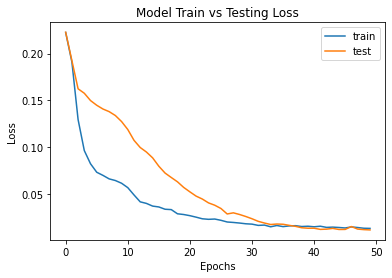

Normalized Test RMSE:  0.10539687321255412 0.11948370003338132 0.1116491591179518 0.09781494597646002
Test RMSE:  208.6858059979164 233.23219720377372 382.6216718247935 0.09781494597646002
Test R-squared:  0.8891816504901304 0.8731091090029435 0.9197012449650829 0.9299482396231884
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 50)             11400     
                                                                 
 dropout_12 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 3, 20)             5680      
                                                                 
 dropout_13 (Dropout)        (None, 3, 20)             0         
                                                                 
 lstm_14 (LSTM)              (None, 

In [5]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 3 
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
# n_train_hours = 1936
n_train_hours = 1694
n_test = 484
train = values[:n_train_hours, :]
test = values[n_train_hours:n_train_hours+n_test, :]
out_test = values[n_train_hours+n_test:, :]
 
#
#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
# history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
 
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

#    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# import xlsxwriter

# # Create file (workbook) and worksheet
# outWorkbook = xlsxwriter.Workbook("out.xlsx")
# outSheet = outWorkbook.add_worksheet()

# # Declare data
# values = [[rmse_1,norm_rmse_1,r_sq1],
#           [rmse_2,norm_rmse_2,r_sq2],
#           [rmse_3,norm_rmse_3,r_sq3],
#           [rmse_4,norm_rmse_4,r_sq4]]

# # Write headers
# outSheet.write("C1", "Tank_1")
# outSheet.write("D1", "Tank_2")
# outSheet.write("E1", "Tank_3")
# outSheet.write("F1", "Pump_1")

# # Write data to file
# outSheet.write("C2",values[0][0])
# outSheet.write("C3",values[0][1])
# outSheet.write("C4",values[0][2])

# outSheet.write("D2",values[1][0])
# outSheet.write("D3",values[1][1])
# outSheet.write("D4",values[1][2])

# outSheet.write("E2",values[2][0])
# outSheet.write("E3",values[2][1])
# outSheet.write("E4",values[2][2])

# outSheet.write("F2",values[3][0])
# outSheet.write("F3",values[3][1])
# outSheet.write("F4",values[3][2])

# outWorkbook.close()

# Save the model to disk
model.save('multi_lstm_model.h5')
print('Model is saved  to disk')

In [19]:
y_hat.shape

(484, 4)

In [20]:
test_X.shape

(484, 18)

### Distribution of the variables

            Tank_1       Tank_2       Tank_3       Pump_1       Pump_2  \
count  2420.000000  2420.000000  2420.000000  2420.000000  2420.000000   
mean    686.320661   714.946281   922.677686     0.300000     0.243802   
std     654.955181   656.051613   942.572849     0.458352     0.429463   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     5.000000    73.250000     0.000000     0.000000   
50%     598.000000   639.500000   747.500000     0.000000     0.000000   
75%    1244.000000  1293.250000  1226.250000     1.000000     0.000000   
max    1980.000000  1952.000000  3427.000000     1.000000     1.000000   

       Flow_sensor_4  
count    2420.000000  
mean     1283.821488  
std      1738.336519  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%      2769.000000  
max      4789.000000  


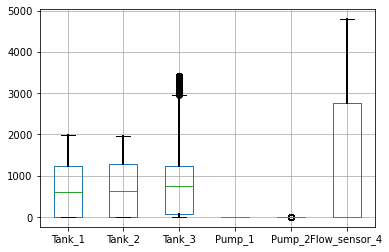

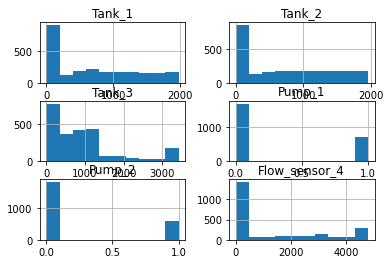

In [4]:
# load results file
results = read_csv('phy_cps.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box plot for rmse

           Tank_1      Tank_2      Tank_3     Pump_1
count   33.000000   33.000000   33.000000  33.000000
mean   144.161401  109.906095  134.719121   0.117114
std     29.680144   35.276328   34.676943   0.009327
min     88.629391   59.307521   74.722553   0.100214
25%    128.229447   79.751047  110.285824   0.109556
50%    142.568261  110.000502  126.947889   0.117160
75%    152.599295  128.335886  152.758458   0.124281
max    210.698327  197.403725  201.181122   0.132437


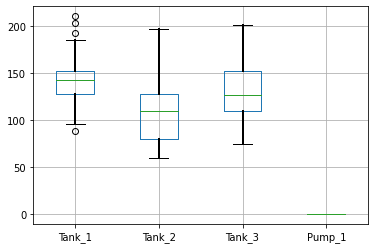

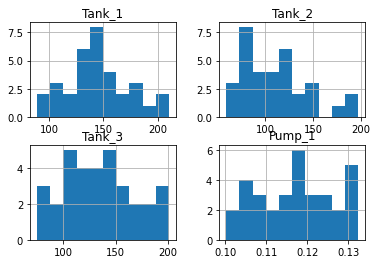

In [1]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box plot for normalised rmse

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.072809   0.056304   0.039311   0.117114
std     0.014990   0.018072   0.010119   0.009327
min     0.044762   0.030383   0.021804   0.100214
25%     0.064762   0.040856   0.032181   0.109556
50%     0.072004   0.056353   0.037043   0.117160
75%     0.077070   0.065746   0.044575   0.124281
max     0.106413   0.101129   0.058705   0.132437


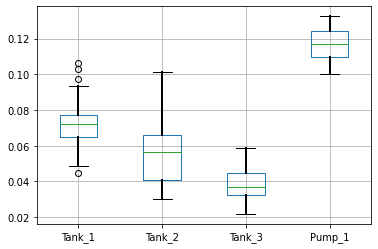

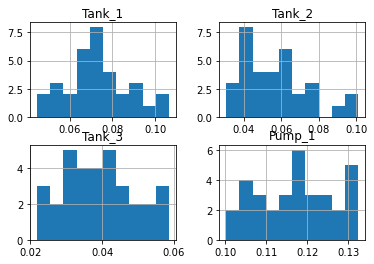

In [2]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('norm_rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box Plot for COefficient of Determination (R-Squared )

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.942453   0.970305   0.910426   0.937769
std     0.023750   0.019602   0.044893   0.009843
min     0.881927   0.912903   0.812304   0.920907
25%     0.938065   0.963188   0.891784   0.930348
50%     0.945940   0.972955   0.925264   0.938101
75%     0.956268   0.985784   0.943595   0.945875
max     0.979108   0.992138   0.974107   0.954713


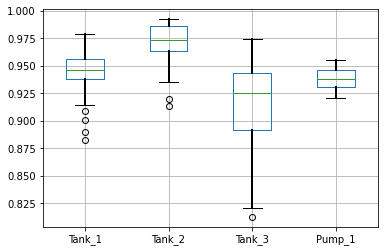

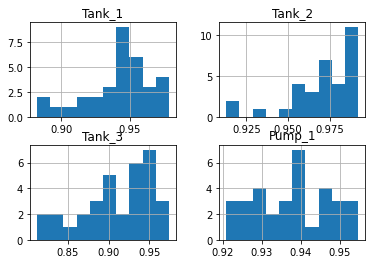

In [3]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('r_sq_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

In [31]:
import math
def rms(x,y):
    total = 0
    for i in range(len(x)):
        total += ((x[i]-y[i])**2)
    return math.sqrt(total/len(x))


p = [10,20,30,40]
q = [11,17,29,40]
print(rms(p,q))
val = [x for x in range(1000,10000,100)]
val2 = [k + 50 for k in val]
# del val2[3]
print(rms(val,val2))

1.6583123951777
50.0


### Training, Vaidating and Testing

Epoch 1/200
27/27 - 5s - loss: 0.2288 - val_loss: 0.1765 - 5s/epoch - 191ms/step
Epoch 2/200
27/27 - 0s - loss: 0.1964 - val_loss: 0.1443 - 269ms/epoch - 10ms/step
Epoch 3/200
27/27 - 0s - loss: 0.1349 - val_loss: 0.1077 - 266ms/epoch - 10ms/step
Epoch 4/200
27/27 - 0s - loss: 0.1063 - val_loss: 0.0970 - 263ms/epoch - 10ms/step
Epoch 5/200
27/27 - 0s - loss: 0.0925 - val_loss: 0.0850 - 266ms/epoch - 10ms/step
Epoch 6/200
27/27 - 0s - loss: 0.0763 - val_loss: 0.0756 - 263ms/epoch - 10ms/step
Epoch 7/200
27/27 - 0s - loss: 0.0636 - val_loss: 0.0636 - 263ms/epoch - 10ms/step
Epoch 8/200
27/27 - 0s - loss: 0.0560 - val_loss: 0.0494 - 263ms/epoch - 10ms/step
Epoch 9/200
27/27 - 0s - loss: 0.0470 - val_loss: 0.0421 - 265ms/epoch - 10ms/step
Epoch 10/200
27/27 - 0s - loss: 0.0455 - val_loss: 0.0431 - 273ms/epoch - 10ms/step
Epoch 11/200
27/27 - 0s - loss: 0.0395 - val_loss: 0.0445 - 265ms/epoch - 10ms/step
Epoch 12/200
27/27 - 0s - loss: 0.0357 - val_loss: 0.0426 - 270ms/epoch - 10ms/step
Epo

Epoch 99/200
27/27 - 0s - loss: 0.0105 - val_loss: 0.0065 - 260ms/epoch - 10ms/step
Epoch 100/200
27/27 - 0s - loss: 0.0105 - val_loss: 0.0061 - 256ms/epoch - 9ms/step
Epoch 101/200
27/27 - 0s - loss: 0.0099 - val_loss: 0.0067 - 255ms/epoch - 9ms/step
Epoch 102/200
27/27 - 0s - loss: 0.0102 - val_loss: 0.0061 - 258ms/epoch - 10ms/step
Epoch 103/200
27/27 - 0s - loss: 0.0097 - val_loss: 0.0059 - 257ms/epoch - 10ms/step
Epoch 104/200
27/27 - 0s - loss: 0.0096 - val_loss: 0.0058 - 261ms/epoch - 10ms/step
Epoch 105/200
27/27 - 0s - loss: 0.0101 - val_loss: 0.0067 - 256ms/epoch - 9ms/step
Epoch 106/200
27/27 - 0s - loss: 0.0103 - val_loss: 0.0061 - 263ms/epoch - 10ms/step
Epoch 107/200
27/27 - 0s - loss: 0.0098 - val_loss: 0.0059 - 260ms/epoch - 10ms/step
Epoch 108/200
27/27 - 0s - loss: 0.0098 - val_loss: 0.0057 - 259ms/epoch - 10ms/step
Epoch 109/200
27/27 - 0s - loss: 0.0096 - val_loss: 0.0063 - 267ms/epoch - 10ms/step
Epoch 110/200
27/27 - 0s - loss: 0.0104 - val_loss: 0.0059 - 261ms/ep

Epoch 196/200
27/27 - 0s - loss: 0.0078 - val_loss: 0.0040 - 265ms/epoch - 10ms/step
Epoch 197/200
27/27 - 0s - loss: 0.0083 - val_loss: 0.0037 - 256ms/epoch - 9ms/step
Epoch 198/200
27/27 - 0s - loss: 0.0078 - val_loss: 0.0038 - 258ms/epoch - 10ms/step
Epoch 199/200
27/27 - 0s - loss: 0.0079 - val_loss: 0.0037 - 257ms/epoch - 10ms/step
Epoch 200/200
27/27 - 0s - loss: 0.0078 - val_loss: 0.0032 - 256ms/epoch - 9ms/step


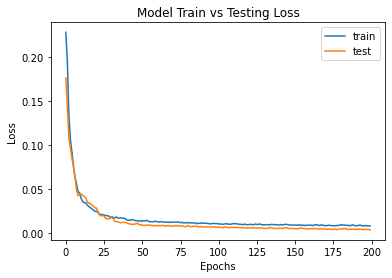

Normalized Test RMSE:  0.043474775077942424 0.028541150940250806 0.03308629420267199 0.09506633621202581
Test RMSE:  86.08005222248067 55.7123304981155 113.38672675709225 0.09506633621202581
Test R-squared:  0.9803567806547433 0.9930628121261265 0.9412389854615365 0.9591595395773522
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 3, 50)             11400     
                                                                 
 dropout_15 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_16 (LSTM)              (None, 3, 20)             5680      
                                                                 
 dropout_16 (Dropout)        (None, 3, 20)             0         
                                                                 
 lstm_17 (LSTM)              (None

In [12]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 3
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
 
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# Save the model to disk
model.save('multi_lstm_model.h5')
print('Model saved to disk')


In [13]:
y_hat.shape

(481, 4)

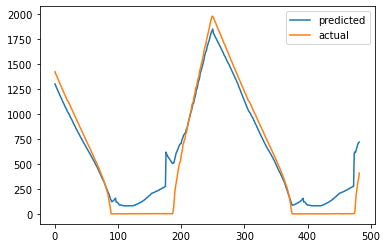

In [4]:
pyplot.plot(inv_yhat[0:500,0], label='predicted')
pyplot.plot(inv_y[0:500,0], label='actual')
pyplot.legend()
pyplot.show()

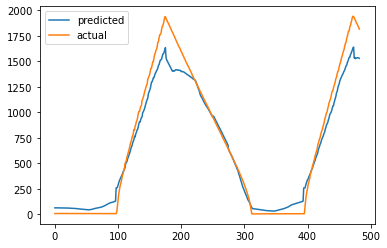

In [5]:
pyplot.plot(inv_yhat[0:500,1], label='predicted')
pyplot.plot(inv_y[0:500,1], label='actual')
pyplot.legend()
pyplot.show()

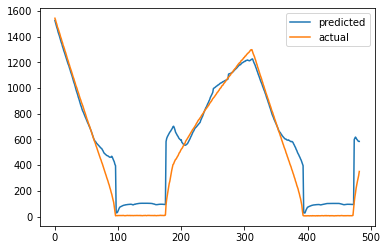

In [6]:
pyplot.plot(inv_yhat[0:500,2], label='predicted')
pyplot.plot(inv_y[0:500,2], label='actual')
pyplot.legend()
pyplot.show()

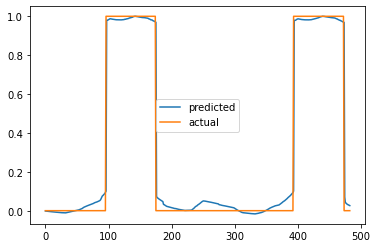

In [7]:
pyplot.plot(inv_yhat[0:500,3], label='predicted')
pyplot.plot(inv_y[0:500,3], label='actual')
pyplot.legend()
pyplot.show()

### Load saved model

In [8]:
from keras.models import load_model

model = load_model('multi_lstm_model.h5')

#split into input and outputs
# n_obs = n_hours * n_features

test_X = out_test[:, :n_obs]
test_y = out_test[:, -n_features:(-n_features+4)]

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# Make a prediction
yhat = model.predict(test_X)

#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:241,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:241,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:241,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:241,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

# #invert scaling for actual
# test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
# inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
# #calculate RMSE - CHANGED to output RMSE for each variable.
# rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
# rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
# rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
# rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

# r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
# r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
# r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
# r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

# print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

# print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)


Normalized Test RMSE:  0.34665625049725524 0.3342687946176971 0.14814945557267675 0.6620504077320962


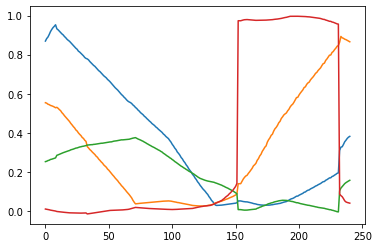

In [51]:
pyplot.plot(yhat[:,])
# pyplot.legend()
pyplot.show()

In [54]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from random import seed
from random import randint
from random import random
from matplotlib import pyplot
import numpy
import random
#seed(1)
# load results file
results = read_csv('phy_cps.csv', header=0)
#values = results.values
#results.drop("wnd_dir", axis=1, inplace=True)
# results["annot"] = "clean"
#print(results.describe())

fault_data = [-30.5, -20.5, 0, 15.5, 25.5]# -40<x<28
n = len(results)

for i in range(n):
    p = random.random()
    if p > 0.8:
        results["Tank_1"].iloc[i] = random.choice(fault_data)
        #results["annot"].iloc[i] = "random"


results.to_csv("faulty_phy_cps.csv")        
print("File saved")


C:\Users\hayatu4islam\AppData\Local\Temp\ipykernel_19904\2972093989.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Tank_1"].iloc[i] = random.choice(fault_data)


File saved


Epoch 1/20
27/27 - 15s - loss: 0.2033 - val_loss: 0.1409 - 15s/epoch - 550ms/step
Epoch 2/20
27/27 - 0s - loss: 0.1239 - val_loss: 0.1015 - 348ms/epoch - 13ms/step
Epoch 3/20
27/27 - 0s - loss: 0.0976 - val_loss: 0.0887 - 342ms/epoch - 13ms/step
Epoch 4/20
27/27 - 0s - loss: 0.0884 - val_loss: 0.0835 - 338ms/epoch - 13ms/step
Epoch 5/20
27/27 - 0s - loss: 0.0761 - val_loss: 0.0792 - 337ms/epoch - 12ms/step
Epoch 6/20
27/27 - 0s - loss: 0.0693 - val_loss: 0.0766 - 336ms/epoch - 12ms/step
Epoch 7/20
27/27 - 0s - loss: 0.0643 - val_loss: 0.0713 - 337ms/epoch - 12ms/step
Epoch 8/20
27/27 - 0s - loss: 0.0598 - val_loss: 0.0665 - 345ms/epoch - 13ms/step
Epoch 9/20
27/27 - 0s - loss: 0.0575 - val_loss: 0.0647 - 344ms/epoch - 13ms/step
Epoch 10/20
27/27 - 0s - loss: 0.0566 - val_loss: 0.0645 - 336ms/epoch - 12ms/step
Epoch 11/20
27/27 - 0s - loss: 0.0552 - val_loss: 0.0617 - 342ms/epoch - 13ms/step
Epoch 12/20
27/27 - 0s - loss: 0.0514 - val_loss: 0.0594 - 337ms/epoch - 12ms/step
Epoch 13/20
2

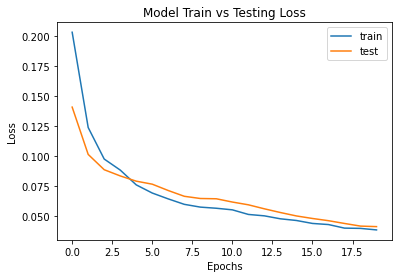

The size of test_X is (479, 5, 6)
Normalized Test RMSE:  0.31413622697712895 0.17623974556378738 0.06731449340261264 0.1752601635342074
Test RMSE:  631.5708837889853 344.0200075940351 230.68676340982375 0.1752601635342074
Test R-squared:  -0.11152280307992135 0.7354785994007851 0.753211204535601 0.8614870544091571
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 50)             11400     
                                                                 
 dropout_12 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 20)             5680      
                                                                 
 dropout_13 (Dropout)        (None, 5, 20)             0         
                                                                 
 l

In [13]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('faulty_phy_cps.csv', header=0, index_col=0)
#df = df.iloc[: , 1:]
dataset = dataset.iloc[:, 1:]
values = dataset.values

#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 5
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
print(f'The size of test_X is {test_X.shape}') 
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# Save the model to disk
model.save('multi_lstm_model.h5')
print('Model saved to disk')


In [14]:
yhat.size

964

In [6]:
# Algorithm to generate discrete random variable
import numpy as np
def multinomial(probs):
    n, u, accum = 0, np.random.uniform(0,1), probs[0]
    while u > accum:
        n = n + 1
        accum = accum + probs[n]
    return n


In [5]:
print(multinomial([2, 93]))

0


In [1]:
print("Animation")

Animation
